## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from modules.index_data import IndexData
from modules.options_data import OptionsData
from modules.strategy import Strategy
from config.expiry_map import expiry_map

plt.style.use("seaborn-v0_8-darkgrid")

## Config

In [2]:
# Config
index_data_loc = "data/NIFTY BANK.csv"
options_data_loc = "data/options/"
start_date = "2021-04"
end_date = "2021-12-30"

# Strat config
index = "BANKNIFTY"
close_time = dt.time(15, 20)
premium = 100

## Load Data & Variables

In [3]:
# Index Data
data = IndexData(
    data_loc=index_data_loc,
    start_date=start_date,
    end_date=end_date,
    expiry_map=expiry_map,
).data

# Options Data
options_obj = OptionsData(data_loc=options_data_loc, expiry_map=expiry_map)

# Strategy
strategy = Strategy(
    index_data=data,
    options_object=options_obj,
    index=index,
    nearest_premium=premium,
    close_time=close_time,
)

## Index Data Sanity Check

### Data Info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69374 entries, 2021-04-01 09:15:00 to 2021-12-30 15:29:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ticker      69374 non-null  object        
 1   open        69374 non-null  float64       
 2   high        69374 non-null  float64       
 3   low         69374 non-null  float64       
 4   close       69374 non-null  float64       
 5   atm_strike  69374 non-null  int64         
 6   spread      69374 non-null  object        
 7   expiry      69374 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 4.8+ MB


### Close

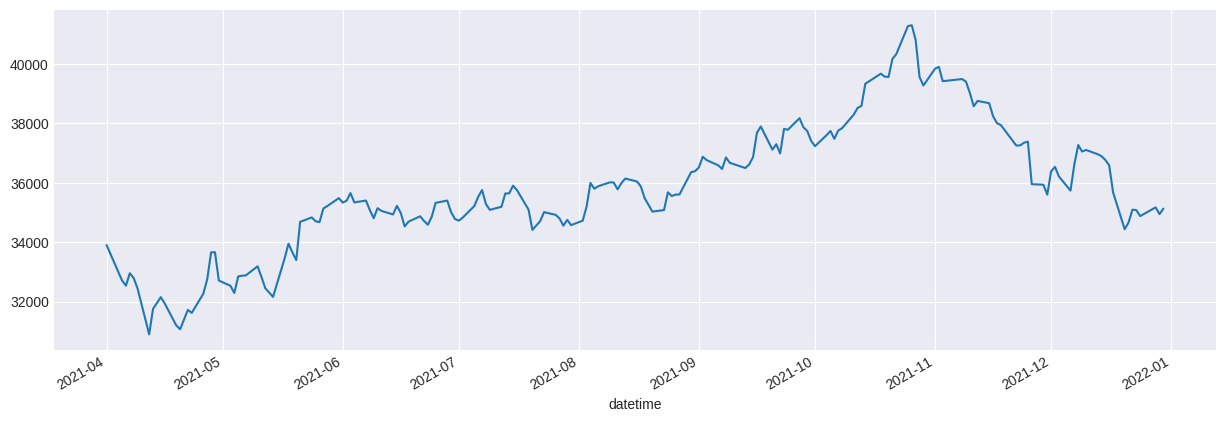

In [5]:
data.resample("D").agg(
    {"open": "first", "high": "max", "low": "min", "close": "last"}
).dropna()["close"].plot(figsize=(15, 5));

No sudden spikes or falls in the close price of the index.

### Standard Deviation

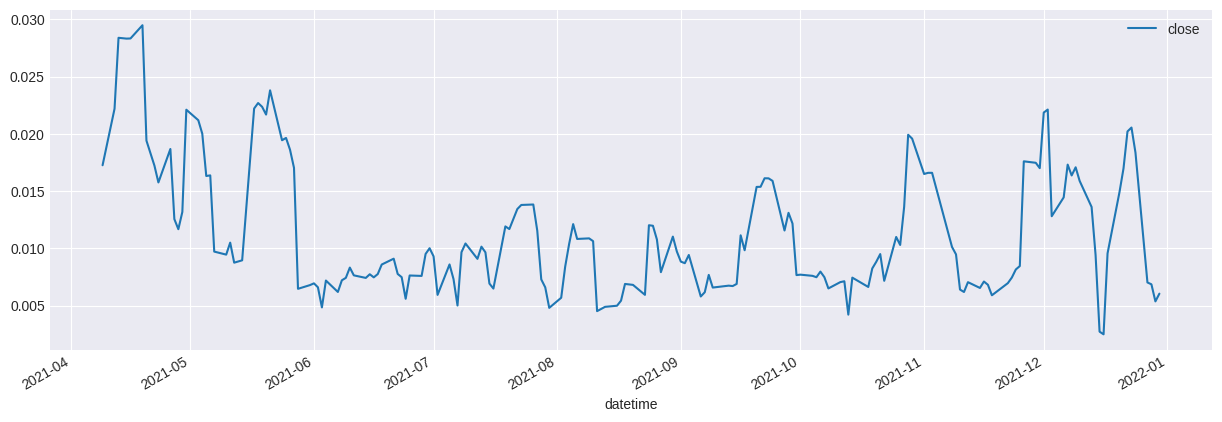

In [6]:
data.resample("D").agg(
    {"open": "first", "high": "max", "low": "min", "close": "last"}
).dropna()[["close"]].pct_change().rolling(window=5).std().plot(
    figsize=(15, 5)
);

Standard Deviation is in a well-defined range

## Strategy

### Run Strategy
The function will take time to run since it is event-based backtesting. It is recommended to load `trade_book.csv` for analysis.

### Analysis
The analysis is not considering any costs of execution for now. Slippage equal to 3% on the negative side is being assumed to take a conservative view.

In [7]:
trade_book = pd.read_csv("trade_book.csv", index_col=[0])
trade_book["datetime"] = pd.to_datetime(trade_book["datetime"])

# Adding 3% slippages
trade_book["price"] = np.where(
    trade_book.price > 0,
    np.round(trade_book.price * 0.97, 2),
    np.round(abs(trade_book.price) * 1.03 * -1, 2),
)
trade_book = trade_book.rename(columns={"price": "points"})
trade_book.head()

,instrument,datetime,points,position_type,expiry
0,BANKNIFTY2140133700CE,2021-04-01 10:48:00,41.81,Entry,2021-04-01 15:30:00
1,BANKNIFTY2140133100PE,2021-04-01 13:05:00,40.30,Entry,2021-04-01 15:30:00
2,BANKNIFTY2140133700CE,2021-04-01 14:10:00,-98.52,SL,2021-04-01 15:30:00
3,BANKNIFTY2140133100PE,2021-04-01 15:20:00,-0.26,Time,2021-04-01 15:30:00
4,BANKNIFTY2140833500CE,2021-04-08 09:51:00,43.26,Entry,2021-04-08 15:30:00


#### PnL

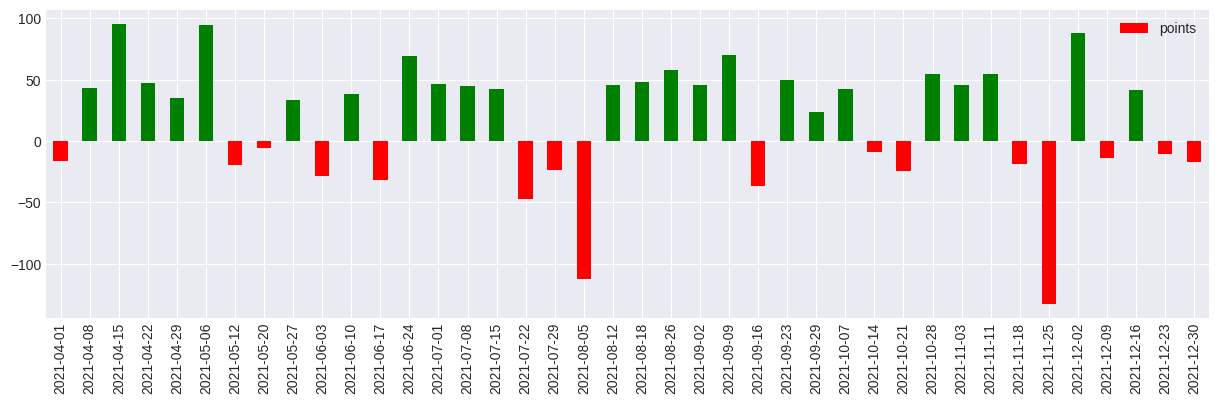


Period: 2021-04-01 to 2021-12-30

Net points  : 711.25
Gross Gained: 1259.05
Gross Lost  : 547.8
Weekly Avg. : 17.78

Max. Gained : 95.8 on 2021-04-15
Max. Lost   : 132.49 on 2021-11-25

Number of Expiries Traded    : 40
Number of Profitable Expiries: 24
Number of Loss  Expiries     : 16
Hit Ratio                    : 60.0%



In [8]:
pnl = trade_book.groupby("expiry").sum(numeric_only=True)
pnl.index = pd.to_datetime(pnl.index).date
pnl["_c"] = np.where(pnl["points"] > 0, "g", "r")
ax = pnl.plot(
    y="points", kind="bar", color=pnl["_c"].to_list(), figsize=(15, 4)
)
plt.show()

print("\nPeriod: 2021-04-01 to 2021-12-30", end="\n")
print(f"\nNet points  : {round(sum(pnl['points']), 2)}")
print(f"Gross Gained: {round(sum(pnl[pnl.points > 0]['points']), 2)}")
print(f"Gross Lost  : {round(-1 * sum(pnl[pnl.points <= 0]['points']), 2)}")
print(f"Weekly Avg. : {round(np.mean(pnl['points']), 2)}", end="\n\n")

max_pt, d = np.max(pnl["points"]), pnl.iloc[np.argmax(pnl["points"])].name
max_lost, l = (
    np.min(pnl["points"]) * -1,
    pnl.iloc[np.argmin(pnl["points"])].name,
)
print(f"Max. Gained : {max_pt} on {d}")
print(f"Max. Lost   : {max_lost} on {l}", end="\n\n")

print(f"Number of Expiries Traded    : {len(pnl)}")
print(f"Number of Profitable Expiries: {(p := len(pnl[pnl['points'] > 0]))}")
print(f"Number of Loss  Expiries     : {(l := len(pnl[pnl['points'] <= 0]))}")
print(f"Hit Ratio                    : {(p / (p + l)) * 100}%", end="\n\n")

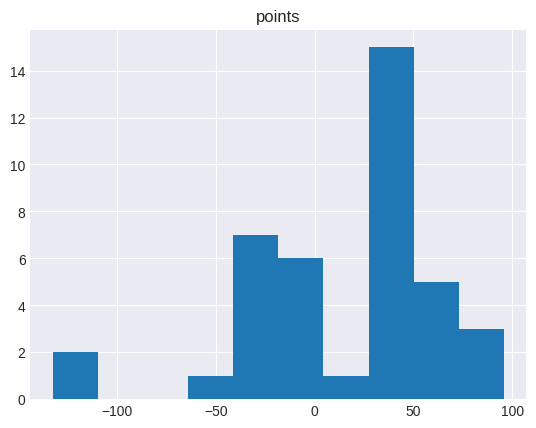

In [9]:
pnl.hist();

The returns are more concentrated on the right. There is a possibility of a big loss, but it is fairly low.

#### Trades
- Time refelects exit of the positions at a specific time
- SL refelcts exit by Stop Loss hit

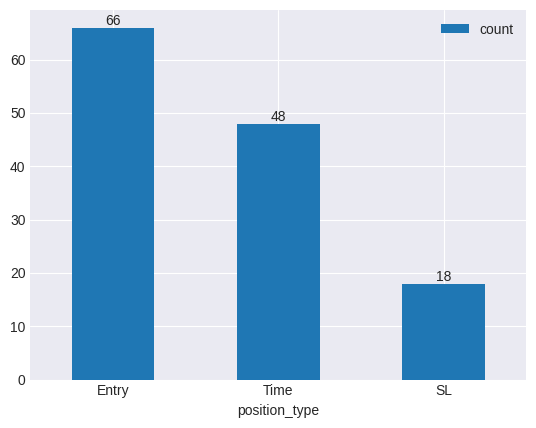

In [10]:
ax = (
    trade_book.groupby("position_type")
    .count()[["instrument"]]
    .rename(columns={"instrument": "count"})
    .sort_values(by="count", ascending=False)
    .plot(kind="bar", rot=0)
)
ax.bar_label(ax.containers[0]);

Almost 72% of the time we exited because of a hard time stop. Rest 18% of the time SL was hit. We could experiment with lowering the SL.

#### Expiries where SL was Hit

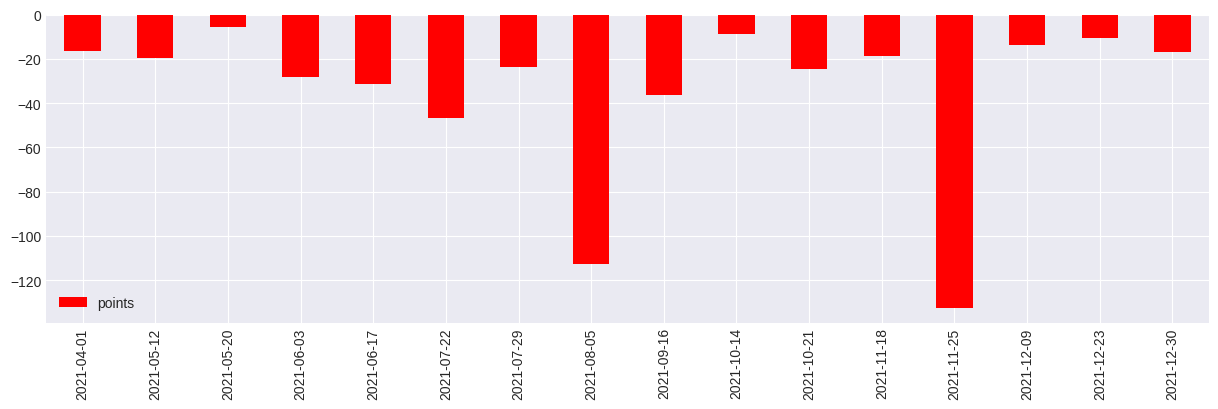

In [11]:
expiry_sl = trade_book[
    trade_book["expiry"].isin(
        trade_book[trade_book["position_type"] == "SL"]["expiry"].to_list()
    )
]
expiry_sl = expiry_sl.groupby("expiry").sum(numeric_only=True)
expiry_sl.index = pd.to_datetime(expiry_sl.index).date
ax = expiry_sl.plot(y="points", kind="bar", color="r", figsize=(15, 4))
plt.show()

There is clearly a systematic pattern to losses. By a simple visual analysis, it is evident that after every 3/4 successive profits, there are 2/3 successive losses. A deep dive can be conducted to find the cyclical nature or the market and take a decision on whether or not to actually trade.

#### Most Common Hours for Entry/Exit
`Blue is Entry | Orange is Exit`

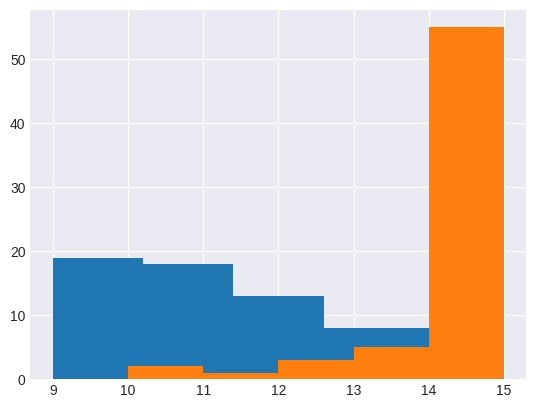

In [12]:
entries = trade_book[trade_book["position_type"] == "Entry"]
exits = trade_book[
    (trade_book["position_type"] == "SL")
    | (trade_book["position_type"] == "Time")
]
entries["datetime"].dt.hour.hist(bins=5)
exits["datetime"].dt.hour.hist(bins=5);

Maximum entries happen in the first 2 hours of the market. Maximum exits happen at close. It would be curious to see that the few exits that happen between 10 and 13 hours are SLs or not. If they are, they could reveal some insights about the market structure that can be leveraged.